In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

from sklearn.preprocessing import binarize
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, matthews_corrcoef


In [ ]:
df = pd.read_csv('/content/labeled_twitter_depressive_full_clean_km2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   text            123984 non-null  object 
 1   depression      123984 non-null  float64
 2   not_depression  123984 non-null  float64
 3   cluster         123984 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.8+ MB


In [ ]:
df = df.drop(['depression', 'not_depression'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     123984 non-null  object
 1   cluster  123984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.shape

(123984, 2)

In [ ]:
df.groupby('cluster').count()

,text
cluster,
0,70509
1,53475


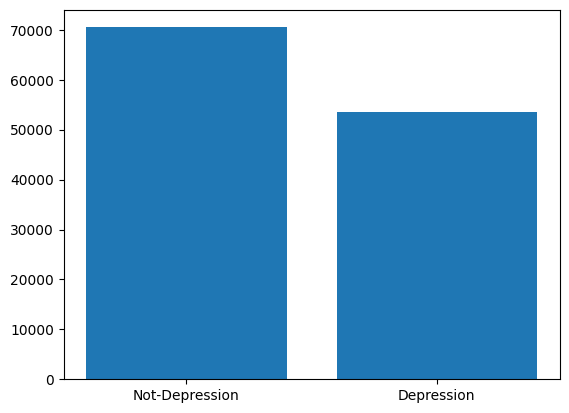

In [ ]:
classes = df.cluster.unique()
counts = []

for i in classes:
  count = len(df[df.cluster==i])
  counts.append(count)

plt.bar(['Not-Depression', 'Depression'], counts)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['cluster'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (123984,)
shape of target variable:  (123984,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=1, random_state=42)
over_X_train, over_y_train = oversample.fit_resample(X_train_vec, y_train)

In [ ]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(over_y_train)))

Original dataset shape Counter({0: 56407, 1: 42780})
Resampled dataset shape Counter({0: 56407, 1: 56407})


In [ ]:
print(np.count_nonzero(over_y_train == 0))
print(np.count_nonzero(over_y_train == 1))

print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

56407
56407
14102
10695


In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

xgbclf = XGBClassifier(learning_rate=0.1, max_depth=15, n_estimators=150)
#xgbclf = XGBClassifier()
xgbclf.fit(over_X_train, over_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Train Metrics...

Accuracy ::  0.8427411491481553

balanced_accuracy 0.8427411491481553

Precision ::  0.8956329554291327

Recall ::  0.7758966085769496

F1-Score ::  0.8314762569699733

MCC ::  0.6916913874695545

ROC AUC ::  0.8427411491481553

Test Metrics...

Accuracy ::  0.803161672782998

balanced_accuracy 0.7928967499130923

Precision ::  0.8044616673648932

Recall ::  0.7181860682561945

F1-Score ::  0.7588796127056266

MCC ::  0.5962088393059081

ROC AUC ::  0.7928967499130922

              precision    recall  f1-score   support

           0       0.80      0.87      0.83     14102
           1       0.80      0.72      0.76     10695

    accuracy                           0.80     24797
   macro avg       0.80      0.79      0.80     24797
weighted avg       0.80      0.80      0.80     24797



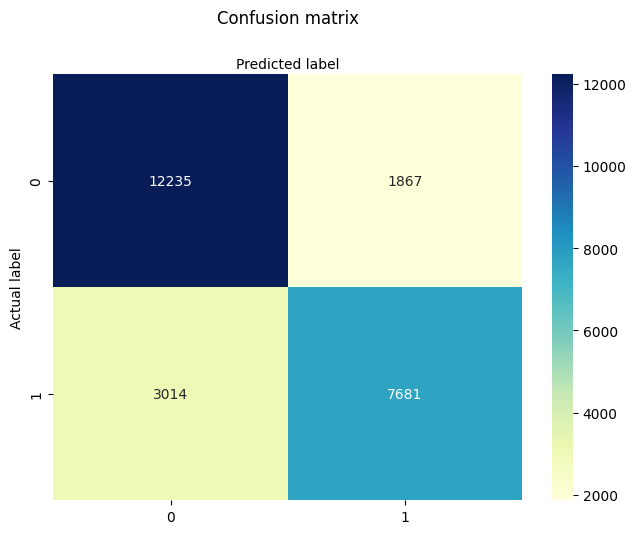

In [ ]:
#predict with the model
y_predict_xgb = xgbclf.predict(X_test_vec)
y_predict_xgb_train = xgbclf.predict(over_X_train)

#calculate and visualize the confusion matrix
cnf=confusion_matrix(y_test, y_predict_xgb)
class_names=[0,1] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Train Metrics
print()
print("Train Metrics...")

print()
print("Accuracy :: ", accuracy_score(over_y_train, y_predict_xgb_train))

print()
print("balanced_accuracy", balanced_accuracy_score(over_y_train, y_predict_xgb_train))

print()
print("Precision :: ", precision_score(over_y_train, y_predict_xgb_train))

print()
print("Recall :: ", recall_score(over_y_train, y_predict_xgb_train))

print()
print("F1-Score :: ", f1_score(over_y_train, y_predict_xgb_train))

print()
print("MCC :: ", matthews_corrcoef(over_y_train, y_predict_xgb_train))

print()
print("ROC AUC :: ", roc_auc_score(over_y_train, y_predict_xgb_train))

# Test Metrics
print()
print("Test Metrics...")

print()
print("Accuracy :: ", accuracy_score(y_test, y_predict_xgb))

print()
print("balanced_accuracy", balanced_accuracy_score(y_test, y_predict_xgb))

print()
print("Precision :: ", precision_score(y_test, y_predict_xgb))

print()
print("Recall :: ", recall_score(y_test, y_predict_xgb))

print()
print("F1-Score :: ", f1_score(y_test, y_predict_xgb))

print()
print("MCC :: ", matthews_corrcoef(y_test, y_predict_xgb))

print()
print("ROC AUC :: ", roc_auc_score(y_test, y_predict_xgb))

print()
print(classification_report(y_test, y_predict_xgb))